# Cluster-Based Parameterization of Vertical Mixing Coefficients in the Ocean Surface Boundary Layer

This notebook extends the analysis carried out by **Sane et al. (2023)** "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks" by implementing a **conditional modeling approach based on clustered ocean states**.

## Motivation

The original paper demonstrated that neural networks can effectively predict vertical mixing shapes in the ocean. However, we hypothesize that **different ocean states might benefit from specialized models**. By clustering the input feature space, we can potentially develop models that are better tailored to specific oceanic conditions, further improving prediction accuracy.

## Approach

1. **Reproduce baseline results** from Sane et al. (2023)
2. **Cluster ocean states** based on physical parameters
3. **Train separate models** for each cluster
4. **Compare performance** of the cluster-specific approach vs. the baseline

## Expected Outcomes

- Identification of distinct oceanic regimes with different mixing behaviors
- Improved prediction accuracy, especially in regions with complex dynamics
- Better understanding of how different physical drivers influence mixing in different regimes

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
from torch import optim
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings
from matplotlib.gridspec import GridSpec

warnings.filterwarnings("ignore", category=FutureWarning)

# Setup notebook environment
today = datetime.today()
np.random.seed(100)
torch.manual_seed(100)

# Fix paths
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# Import custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.cluster_visualizations import (
    plot_cluster_distributions,
    plot_shape_functions_by_cluster,
    plot_cluster_size_distribution,
    plot_cluster_centers,
    plot_model_performance_comparison,
    plot_sample_predictions,
    plot_error_distributions,
    plot_overall_performance_comparison
)

# Set up directories
cwd_data = cwd + '/Data/'
cwd_output = cwd + '/output/'
os.makedirs(cwd_output, exist_ok=True)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [2]:
%%capture
import importlib

# Check and install required packages
if importlib.util.find_spec("torch") is None:
    !pip install torch
if importlib.util.find_spec("zarr") is None:
    !pip install zarr
if importlib.util.find_spec("scikit-learn") is None:
    !pip install scikit-learn

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [ ]:
# This cell has been removed as the imports are already in cell 1

## 1.1 Load and Preprocess Data

We'll load the GOTM (General Ocean Turbulence Model) data provided by Sane et al. (2023) and apply the same preprocessing steps.

In [4]:
# Load GOTM training data produced by Sane et al. 2023
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# Coriolis parameter calculation
def corio(lat):
    return 2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

# Extract variables
l0 = corio(d['l'][:])
b00 = d['b0'][:]
ustar0 = d['ustar'][:]
h0 = d['h'][:]
lat0 = d['lat'][:]
heat0 = d['heat'][:]
tx0 = d['tx'][:]
tx0 = np.round(tx0, 2)
SF0 = d['SF'][:]

# Print summary of input shape
print(f"Data shape: {SF0.shape}, representing {SF0.shape[0]} samples with {SF0.shape[1]} vertical levels")

Data shape: (1335185, 16), representing 1335185 samples with 16 vertical levels


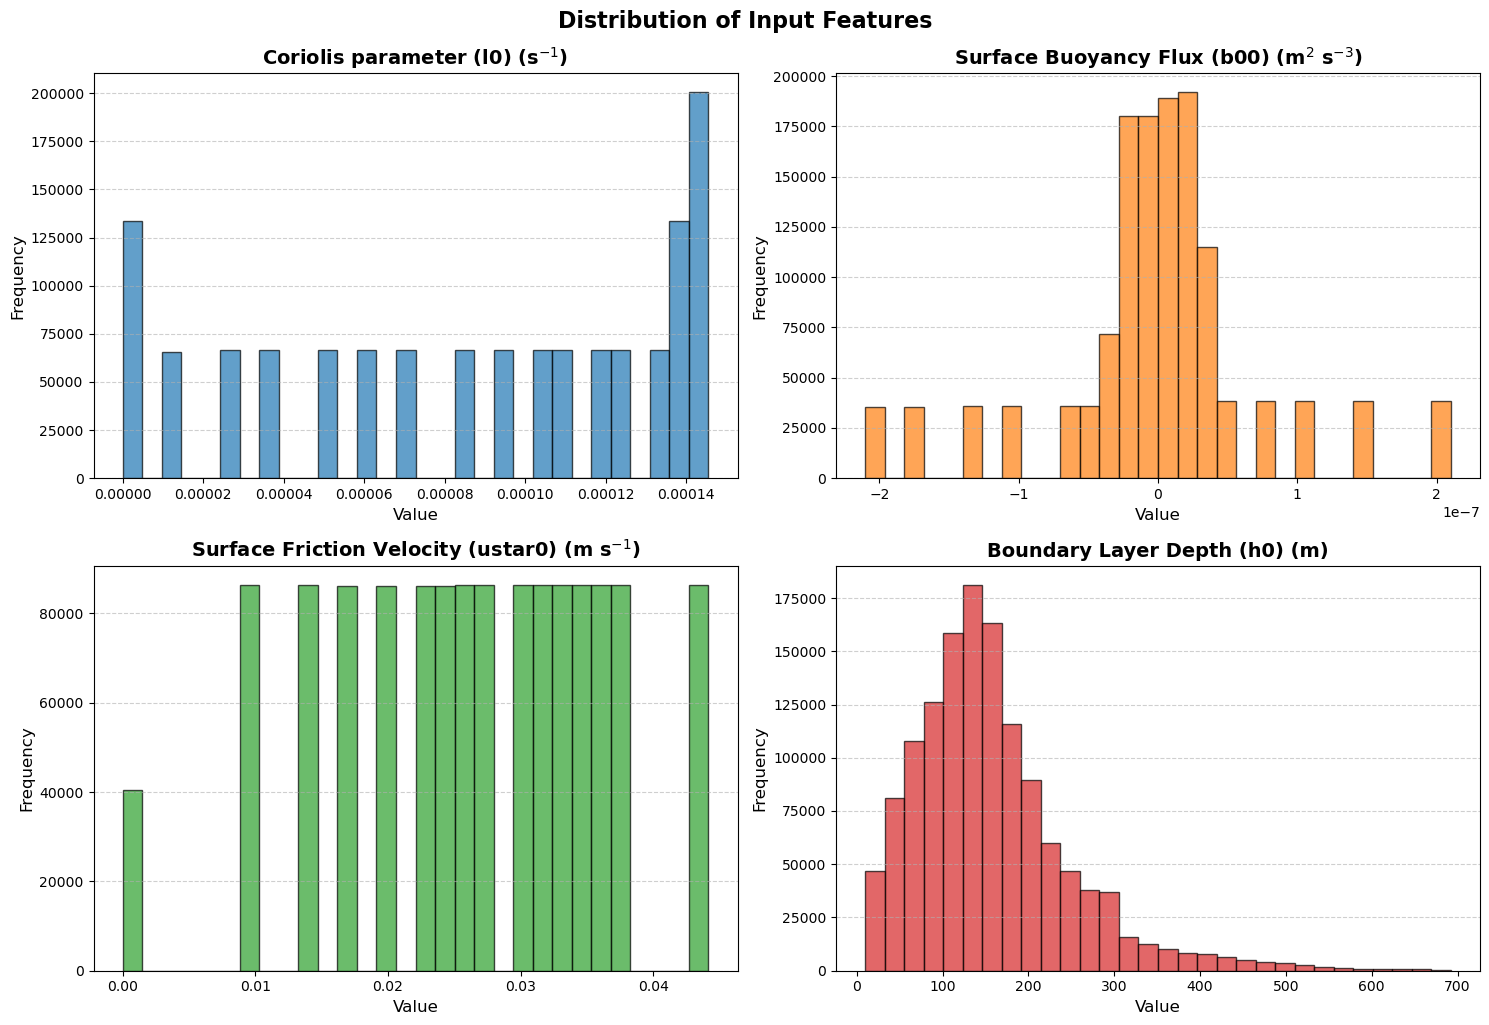

In [5]:
# Quick visualization of input features
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0.values.flatten()
}

# Create histograms with improved styling
plt.figure(figsize=(15, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (name, data) in enumerate(variables.items()):
    plt.subplot(2, 2, i + 1)
    plt.hist(data, bins=30, color=colors[i], alpha=0.7, edgecolor='black')
    plt.title(name, fontsize=14, fontweight='bold')
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.suptitle("Distribution of Input Features", fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [6]:
# Apply the same filtering criteria as in Sane et al. (2023)
ind101 = np.where(np.abs(heat0) < 601)[0]
ind1 = ind101
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]

# Combine all filters
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# Prepare data for model training
mm1 = 0; mm2 = 16  # 16 levels (level 1 at bottom, level 16 at top)
data_load_main = np.zeros([len(h0[ind7]), 4 + mm2 - mm1])
data_load_main[:, 0] = l0[ind7]     # Coriolis parameter
data_load_main[:, 1] = b00[ind7]    # Surface buoyancy flux
data_load_main[:, 2] = ustar0[ind7] # Surface friction velocity
data_load_main[:, 3] = h0[ind7]     # Boundary layer depth
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2] # Shape functions

# Store additional forcing variables for reference
data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]  # Latitude
data_forc[:, 1] = heat0[ind7] # Heat flux
data_forc[:, 2] = tx0[ind7]   # Wind stress

# Create a copy of the data for processing
data_load3 = copy.deepcopy(data_load_main)

# Preprocess data using the same function as in the original code
print('Preprocessing data...')
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)
print('Done preprocessing')

Preprocessing data...
Done preprocessing


In [7]:
# Load validation data
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df.iloc[:, 3:].values

# Apply same filtering criteria
ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)

# Extract and normalize validation features
valid_x = valid_data[ind, 0:4]
valid_x[:, 0] = (valid_x[:, 0] - stats[0]) / stats[1]  # Normalize Coriolis
valid_x[:, 1] = (valid_x[:, 1] - stats[2]) / stats[3]  # Normalize buoyancy flux
valid_x[:, 2] = (valid_x[:, 2] - stats[4]) / stats[5]  # Normalize friction velocity
valid_x[:, 3] = (valid_x[:, 3] - stats[6]) / stats[7]  # Normalize layer depth

# Extract and normalize validation targets
valid_y = valid_data[ind, 5:]
for i in range(len(valid_y)):
    valid_y[i, :] = np.log(valid_y[i, :] / np.max(valid_y[i, :]))
for i in range(16):
    valid_y[:, i] = (valid_y[:, i] - k_mean[i]) / k_std[i]

# Convert to PyTorch tensors
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)

print(f"Training data shape: {x.shape}, {y.shape}")
print(f"Validation data shape: {valid_x.shape}, {valid_y.shape}")

Training data shape: torch.Size([917858, 4]), torch.Size([917858, 16])
Validation data shape: torch.Size([89899, 4]), torch.Size([89899, 16])


## 1.2 Define the Neural Network Model

We'll use the same architecture as in the original paper: a multilayer perceptron with 2 hidden layers and 32 neurons per layer.

In [8]:
class OceanMixingNN(nn.Module):
    def __init__(self, in_nodes, hidden_nodes, out_nodes):
        super(OceanMixingNN, self).__init__()
        self.linear1 = nn.Linear(in_nodes, hidden_nodes)
        self.linear2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.linear3 = nn.Linear(hidden_nodes, out_nodes)
        self.dropout = nn.Dropout(0.25)  # Regularization
        
        # Initialize weights using the same approach as in original paper
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        return self.linear3(x)

In [9]:
def train_model(model, x, y, valid_x, valid_y, k_mean, k_std, epochs=3000, lr=1e-3, patience=50):
    """Train a model with early stopping based on validation loss"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss(reduction='mean')
    losses = []
    
    # Convert k_mean and k_std to tensors on appropriate device
    k_mean_tensor = torch.tensor(k_mean, dtype=torch.float32).to(device)
    k_std_tensor = torch.tensor(k_std, dtype=torch.float32).to(device)
    
    # For early stopping
    best_loss = float('inf')
    best_model = None
    no_improve = 0
    
    with tqdm(total=epochs, desc="Training") as pbar:
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            train_pred = model(x)
            
            # Compute loss (same as in original paper)
            loss = loss_fn(train_pred, y)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Validation
            model.eval()
            with torch.no_grad():
                valid_pred = model(valid_x)
                
                # Calculate loss in original space, not normalized space
                train_loss = torch.mean(torch.abs(
                    torch.exp(train_pred * k_std_tensor + k_mean_tensor) - 
                    torch.exp(y * k_std_tensor + k_mean_tensor)
                ))
                
                valid_loss = torch.mean(torch.abs(
                    torch.exp(valid_pred * k_std_tensor + k_mean_tensor) - 
                    torch.exp(valid_y * k_std_tensor + k_mean_tensor)
                ))
            
            # Store losses
            losses.append((epoch, train_loss.item(), valid_loss.item()))
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                'train_loss': f"{train_loss.item():.4f}", 
                'valid_loss': f"{valid_loss.item():.4f}",
                'patience': no_improve
            })
            
            # Early stopping
            if valid_loss.item() < best_loss:
                best_loss = valid_loss.item()
                best_model = copy.deepcopy(model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break
    
    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, np.array(losses)

## 1.3 Train the Baseline Model

First, we'll train a single model on all data, following the exact approach in Sane et al. (2023).

In [10]:
# Define model parameters
in_nodes = 4      # 4 input features
hidden_nodes = 32 # 32 nodes per hidden layer
out_nodes = 16    # 16 output points (one for each sigma level)

# Initialize and train the baseline model
print("Training baseline model on all data...")
baseline_model = OceanMixingNN(in_nodes, hidden_nodes, out_nodes).to(device)
baseline_model, baseline_losses = train_model(
    baseline_model, x, y, valid_x, valid_y, k_mean, k_std
)

Training baseline model on all data...


Training:  44%|████▎     | 1309/3000 [00:42<00:55, 30.59it/s, train_loss=0.0375, valid_loss=0.0479, patience=49]


Early stopping at epoch 1309


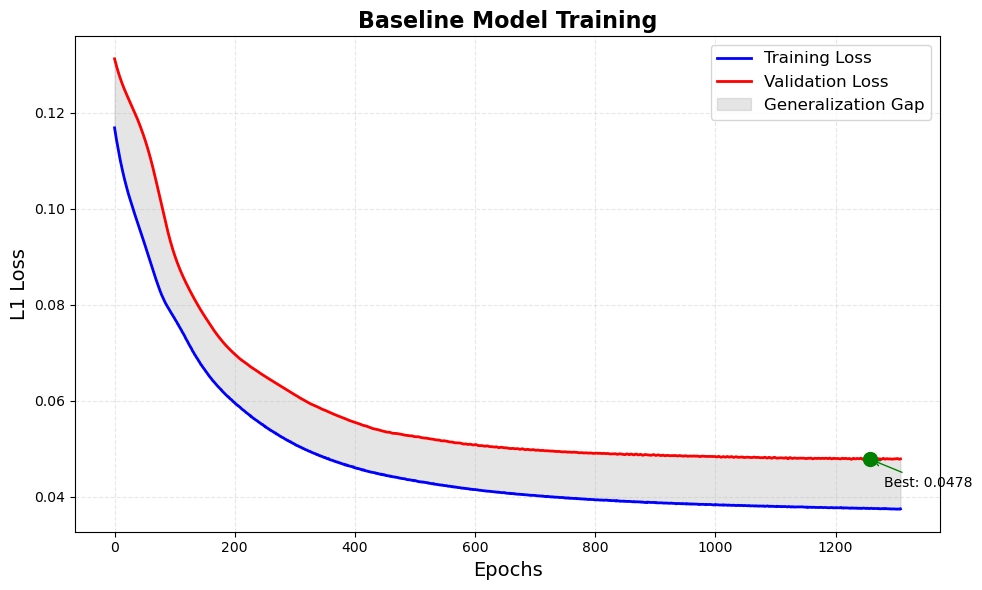

In [11]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
epochs = baseline_losses[:, 0]
train_loss = baseline_losses[:, 1]
valid_loss = baseline_losses[:, 2]

plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
plt.plot(epochs, valid_loss, 'r-', linewidth=2, label='Validation Loss')
plt.fill_between(epochs, train_loss, valid_loss, alpha=0.2, color='gray', label='Generalization Gap')

# Add the best validation loss
best_epoch = np.argmin(valid_loss)
best_valid = valid_loss[best_epoch]
plt.scatter(epochs[best_epoch], best_valid, c='g', s=100, zorder=3)
plt.annotate(f'Best: {best_valid:.4f}', 
             (epochs[best_epoch], best_valid),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='green'))

plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('L1 Loss', fontsize=14)
plt.title('Baseline Model Training', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Clustering Analysis

Now we'll implement our extension to the original approach by clustering the ocean states and training separate models for each cluster.

## 2.1 Feature Clustering

We'll cluster the input data based on the four physical parameters: Coriolis parameter, surface buoyancy flux, surface friction velocity, and boundary layer depth.

In [ ]:
def evaluate_clusters(features, max_clusters=10, sample_size=10000, timeout_seconds=120):
    """
    Simple function to iterate through cluster numbers and calculate silhouette scores.
    Uses data sampling to make computation feasible for large datasets.
    
    Parameters:
        features: Input features array
        max_clusters: Maximum number of clusters to evaluate
        sample_size: Maximum number of samples to use for silhouette calculation
        timeout_seconds: Maximum seconds to run before stopping
        
    Returns:
        best_k: Number of clusters with the highest silhouette score
    """
    import time
    import random
    
    start_time = time.time()
    print(f"Dataset shape: {features.shape}")
    
    # Sample data if it's too large
    if len(features) > sample_size:
        print(f"Sampling {sample_size} points from {len(features)} for silhouette calculation")
        indices = random.sample(range(len(features)), sample_size)
        sampled_features = features[indices]
    else:
        print("Using entire dataset")
        sampled_features = features
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(sampled_features)
    
    # Store scores
    scores = []
    
    # Try different numbers of clusters
    for k in range(2, max_clusters + 1):
        # Check if we've exceeded the timeout
        if time.time() - start_time > timeout_seconds:
            print(f"Timeout of {timeout_seconds} seconds reached after testing {len(scores)} clusters")
            break
            
        iter_start = time.time()
        print(f"Evaluating k={k} clusters...")
        
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_features)
        
        kmeans_time = time.time() - iter_start
        print(f"  K-means completed in {kmeans_time:.2f} seconds")
        
        # Calculate silhouette score
        silhouette_start = time.time()
        score = silhouette_score(scaled_features, labels)
        silhouette_time = time.time() - silhouette_start
        
        scores.append((k, score))
        print(f"  Silhouette score: {score:.4f} (calculated in {silhouette_time:.2f} seconds)")
    
    total_time = time.time() - start_time
    print(f"Total evaluation time: {total_time:.2f} seconds")
    
    if not scores:
        print("No scores calculated due to timeout. Using default k=4")
        return 4
    
    # Plot the results
    k_values = [k for k, _ in scores]
    silhouette_values = [score for _, score in scores]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_values, 'o-', linewidth=2)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Score by Number of Clusters', fontsize=14)
    
    # Highlight the best score
    best_k = k_values[silhouette_values.index(max(silhouette_values))]
    plt.axvline(best_k, color='r', linestyle='--', alpha=0.5)
    plt.text(best_k+0.1, min(silhouette_values), f'Best k={best_k}', 
             verticalalignment='bottom', color='r')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best number of clusters: {best_k}")
    return best_k

In [ ]:
# Get original (non-normalized) input features for clustering
original_features = data_load_main[:, :4].astype(np.float64)

# Option 1: Use a fixed number of clusters (faster, recommended for start)
n_clusters = 4
print(f"Using a fixed number of clusters: {n_clusters}")

# Option 2: Uncomment to evaluate different cluster numbers
# Use a small sample (5000) and set a reasonable timeout (60 seconds)
# n_clusters = evaluate_clusters(
#     original_features, 
#     max_clusters=8,
#     sample_size=5000,  # Only use 5000 samples for evaluation
#     timeout_seconds=60  # Stop after 60 seconds
# )

In [ ]:
def visualize_shape_functions(data_load_main, cluster_assignments, n_clusters):
    """
    Visualize the shape functions for each cluster.
    
    Parameters:
        data_load_main: Raw data containing shape functions
        cluster_assignments: Cluster labels
        n_clusters: Number of clusters
    """
    # Extract input features
    features = data_load_main[:, :4]
    feature_names = ['Coriolis Parameter', 'Surface Buoyancy Flux', 
                     'Surface Friction Velocity', 'Boundary Layer Depth']
    
    # Visualize shape functions by cluster
    print("Visualizing mean shape functions by cluster...")
    shape_function_fig = plot_shape_functions_by_cluster(data_load_main, cluster_assignments, n_clusters)
    
    # We skip the 2D projections as they're not very informative
    
    return shape_function_fig

In [18]:
def visualize_shape_functions(data_load_main, cluster_assignments, n_clusters):
    """
    Visualize the shape functions for each cluster and 2D projections of clusters.
    
    Parameters:
        data_load_main: Raw data containing shape functions
        cluster_assignments: Cluster labels
        n_clusters: Number of clusters
    """
    # Extract input features
    features = data_load_main[:, :4]
    feature_names = ['Coriolis Parameter', 'Surface Buoyancy Flux', 
                     'Surface Friction Velocity', 'Boundary Layer Depth']
    
    # Visualize shape functions by cluster
    print("Visualizing mean shape functions by cluster...")
    shape_function_fig = plot_shape_functions_by_cluster(data_load_main, cluster_assignments, n_clusters)
    
    # Visualize 2D projections of features colored by cluster
    print("Visualizing 2D projections of clusters...")
    projection_fig = plot_cluster_2d_projections(features, cluster_assignments, n_clusters, feature_names)
    
    return shape_function_fig, projection_fig

Clustering the data with 4 clusters...
Cluster 0: 228400 samples (24.88%)
Cluster 1: 87582 samples (9.54%)
Cluster 2: 242490 samples (26.42%)
Cluster 3: 359386 samples (39.15%)

Visualizaing cluster feature distributions...

Visualizaing cluster centers...

Visualizaing cluster size distribution...

Cluster Centers and Statistics:


,Coriolis,Buoyancy Flux,Friction Velocity,Layer Depth,Coriolis StdDev,Buoyancy Flux StdDev,Friction Velocity StdDev,Layer Depth StdDev
Cluster 0,0.000034,1.298690e-08,0.024815,203.577596,0.000030,6.532035e-08,0.005975,51.701952
Cluster 1,0.000096,-1.508436e-07,0.024146,97.221312,0.000043,4.540683e-08,0.005894,45.983377
Cluster 2,0.000093,1.566197e-08,0.012239,78.805021,0.000044,5.055168e-08,0.006027,33.525784
Cluster 3,0.000122,1.615856e-08,0.026855,127.988316,0.000023,5.454863e-08,0.004209,35.653490


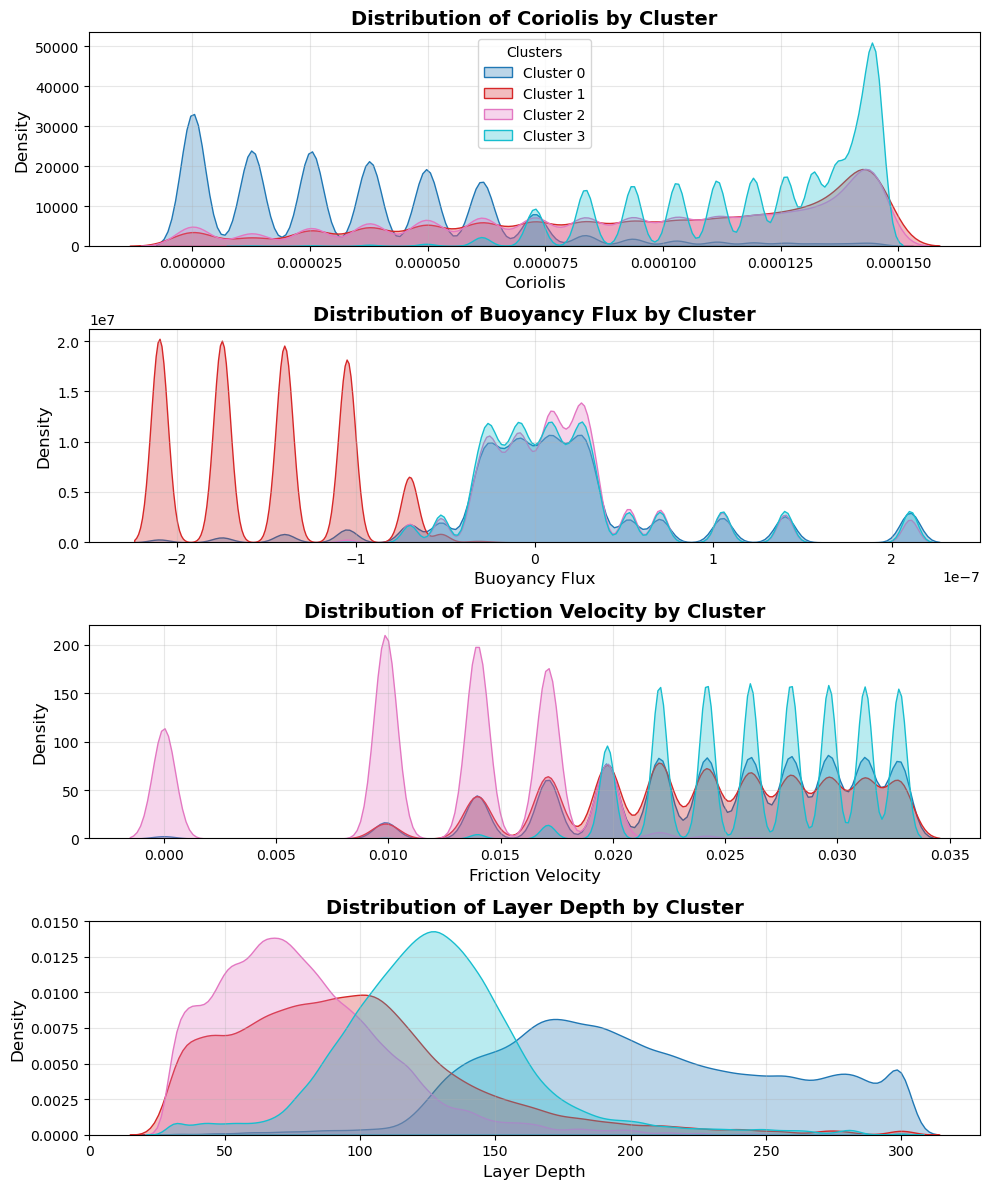

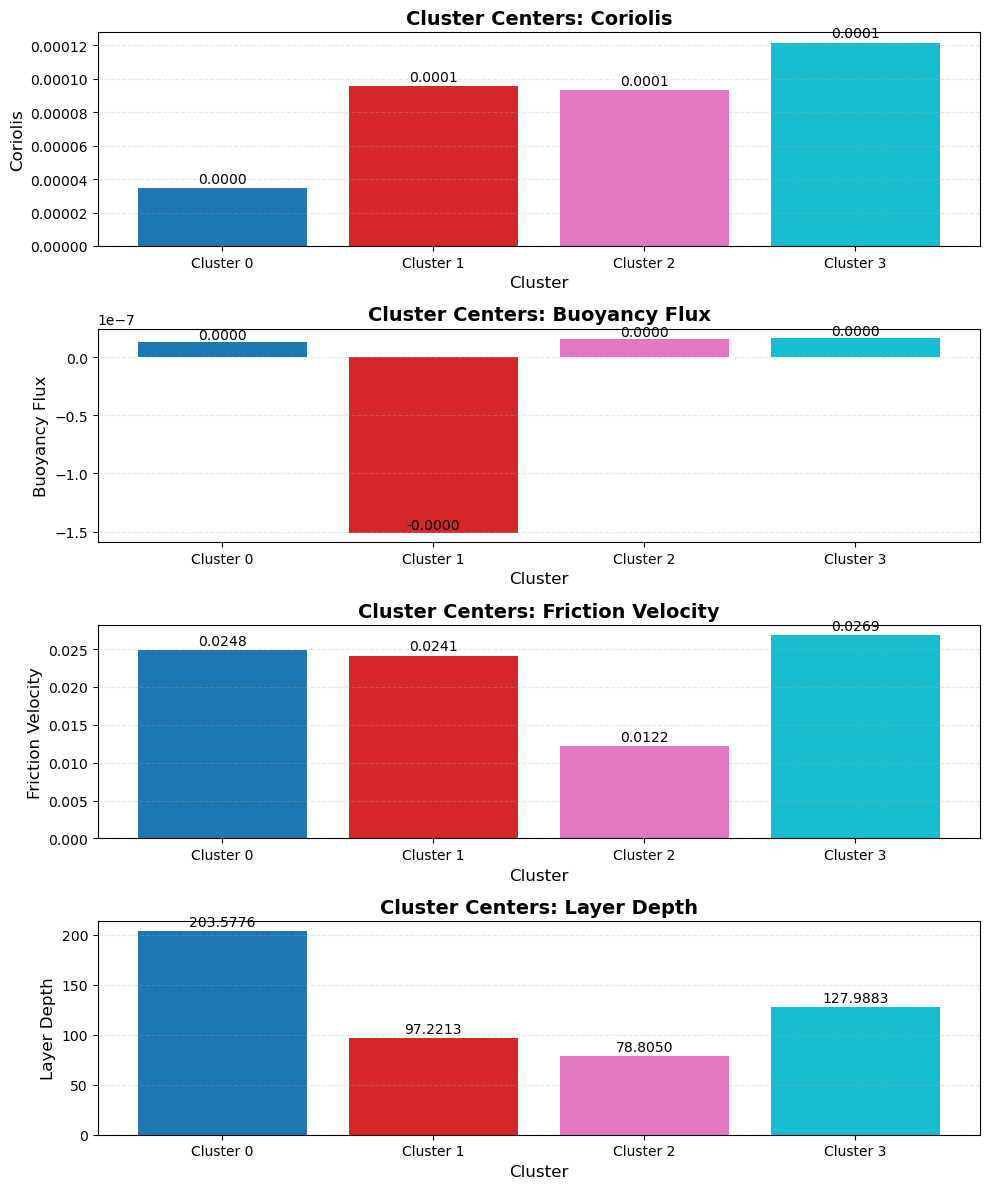

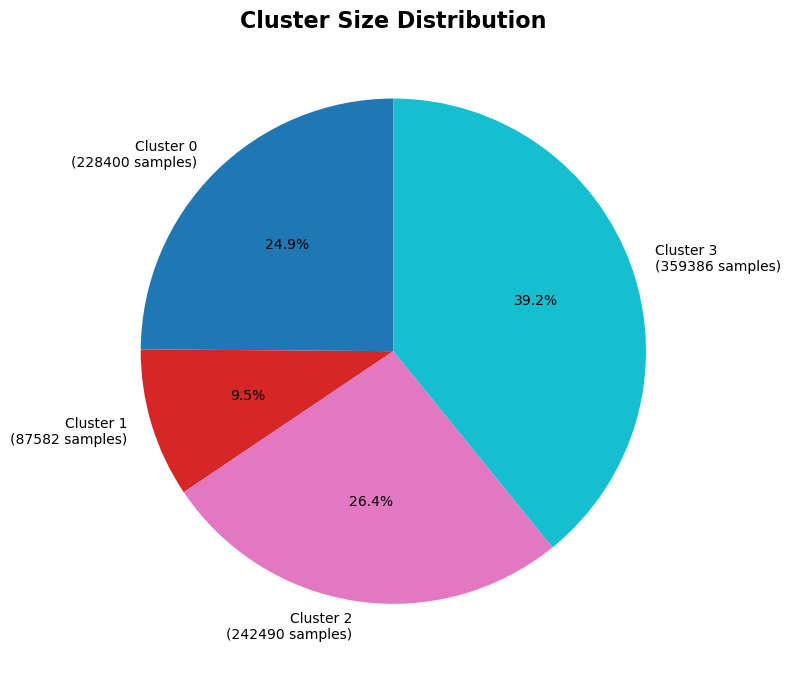

In [19]:
# Cluster the data
print("Clustering the data with", n_clusters, "clusters...")
cluster_assignments, scaler, kmeans, cluster_stats = cluster_data(original_features, n_clusters)

# Display cluster statistics for better understanding
print("\nCluster Centers and Statistics:")
display(cluster_stats)

In [ ]:
# Visualize the clusters
shape_function_fig = visualize_shape_functions(data_load_main, cluster_assignments, n_clusters)

## 2.2 Train Cluster-Specific Models

Now we'll train separate models for each cluster and compare their performance with the baseline model.

In [23]:
def train_cluster_models(x, y, valid_x, valid_y, k_mean, k_std, cluster_assignments, n_clusters):
    """Train separate models for each cluster"""
    # Convert variables to numpy for indexing
    x_np = x.cpu().numpy()
    y_np = y.cpu().numpy()
    
    # Initialize a dictionary to store models
    cluster_models = {}
    cluster_losses = {}
    
    # Train a model for each cluster
    for cluster_id in range(n_clusters):
        print(f"\nTraining model for Cluster {cluster_id}")
        
        # Clear CUDA cache to avoid memory issues
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Get data points belonging to this cluster
        cluster_mask = cluster_assignments == cluster_id
        x_cluster = torch.FloatTensor(x_np[cluster_mask]).to(device)
        y_cluster = torch.FloatTensor(y_np[cluster_mask]).to(device)
        
        print(f"Cluster {cluster_id} data shape: {x_cluster.shape}, {y_cluster.shape}")
        
        # Initialize and train model
        model = OceanMixingNN(in_nodes, hidden_nodes, out_nodes).to(device)
        
        # Adjust patience based on cluster size to avoid early stopping
        cluster_size = x_cluster.shape[0]
        adjusted_patience = max(20, min(50, int(cluster_size / 100)))
        print(f"Using patience of {adjusted_patience} epochs for early stopping")
        
        model, losses = train_model(
            model, x_cluster, y_cluster, valid_x, valid_y, k_mean, k_std,
            patience=adjusted_patience
        )
        
        # Store model and losses
        cluster_models[cluster_id] = model
        cluster_losses[cluster_id] = losses
    
    return cluster_models, cluster_losses

In [24]:
# Train cluster-specific models
cluster_models, cluster_losses = train_cluster_models(
    x, y, valid_x, valid_y, k_mean, k_std, cluster_assignments, n_clusters
)


Training model for Cluster 0
Cluster 0 data shape: torch.Size([228400, 4]), torch.Size([228400, 16])
Using patience of 50 epochs for early stopping


Training:  67%|██████▋   | 2022/3000 [00:21<00:10, 94.97it/s, train_loss=0.0350, valid_loss=0.0438, patience=49]



Early stopping at epoch 2022

Training model for Cluster 1
Cluster 1 data shape: torch.Size([87582, 4]), torch.Size([87582, 16])
Using patience of 50 epochs for early stopping


Training:  65%|██████▌   | 1952/3000 [00:11<00:06, 174.55it/s, train_loss=0.0344, valid_loss=0.0428, patience=49]



Early stopping at epoch 1952

Training model for Cluster 2
Cluster 2 data shape: torch.Size([242490, 4]), torch.Size([242490, 16])
Using patience of 50 epochs for early stopping


Training:  67%|██████▋   | 2019/3000 [00:21<00:10, 92.10it/s, train_loss=0.0340, valid_loss=0.0429, patience=49]



Early stopping at epoch 2019

Training model for Cluster 3
Cluster 3 data shape: torch.Size([359386, 4]), torch.Size([359386, 16])
Using patience of 50 epochs for early stopping


Training:  43%|████▎     | 1294/3000 [00:19<00:25, 67.96it/s, train_loss=0.0373, valid_loss=0.0478, patience=49]


Early stopping at epoch 1294


In [25]:
# This function is simple enough to keep as is
def plot_cluster_losses(cluster_losses, n_clusters):
    """Plot training and validation losses for each cluster model"""
    # Set up colors
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    plt.figure(figsize=(12, 8))
    
    for i in range(n_clusters):
        losses = cluster_losses[i]
        epochs = losses[:, 0]
        valid_loss = losses[:, 2]
        
        plt.plot(epochs, valid_loss, '-', color=colors[i], linewidth=2, 
                label=f'Cluster {i} Validation Loss')
        
        # Mark the best validation loss
        best_epoch = np.argmin(valid_loss)
        best_valid = valid_loss[best_epoch]
        plt.scatter(epochs[best_epoch], best_valid, c=colors[i], s=80, zorder=3)
        
    # Add baseline validation loss for comparison
    baseline_epochs = baseline_losses[:, 0]
    baseline_valid = baseline_losses[:, 2]
    plt.plot(baseline_epochs, baseline_valid, 'k-', linewidth=3, 
            label='Baseline Validation Loss')
    
    best_baseline_epoch = np.argmin(baseline_valid)
    best_baseline = baseline_valid[best_baseline_epoch]
    plt.scatter(baseline_epochs[best_baseline_epoch], best_baseline, c='k', s=100, zorder=3)
    plt.annotate(f'Baseline: {best_baseline:.4f}', 
                 (baseline_epochs[best_baseline_epoch], best_baseline),
                 xytext=(10, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Validation Loss', fontsize=14)
    plt.title('Validation Losses by Cluster', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return plt.gcf()

/tmp/ipykernel_2254/3116365661.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(epochs[best_epoch], best_valid, c=colors[i], s=80, zorder=3)


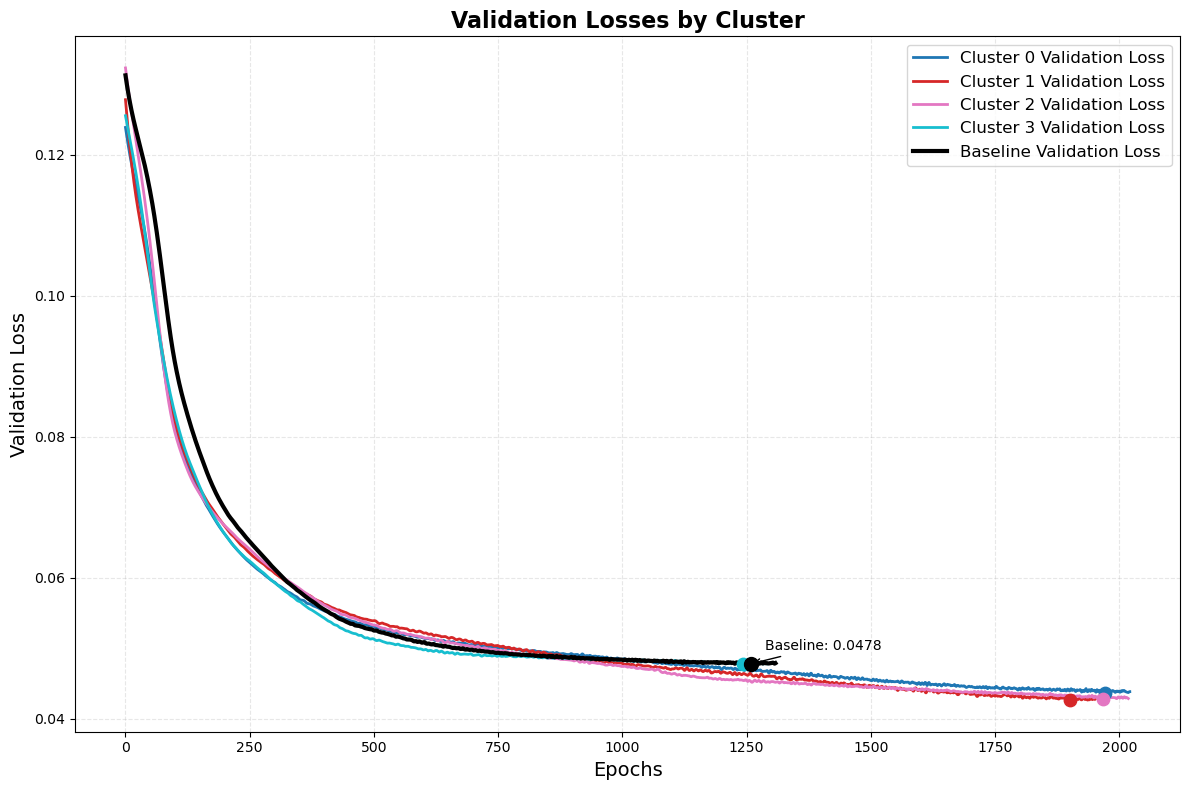

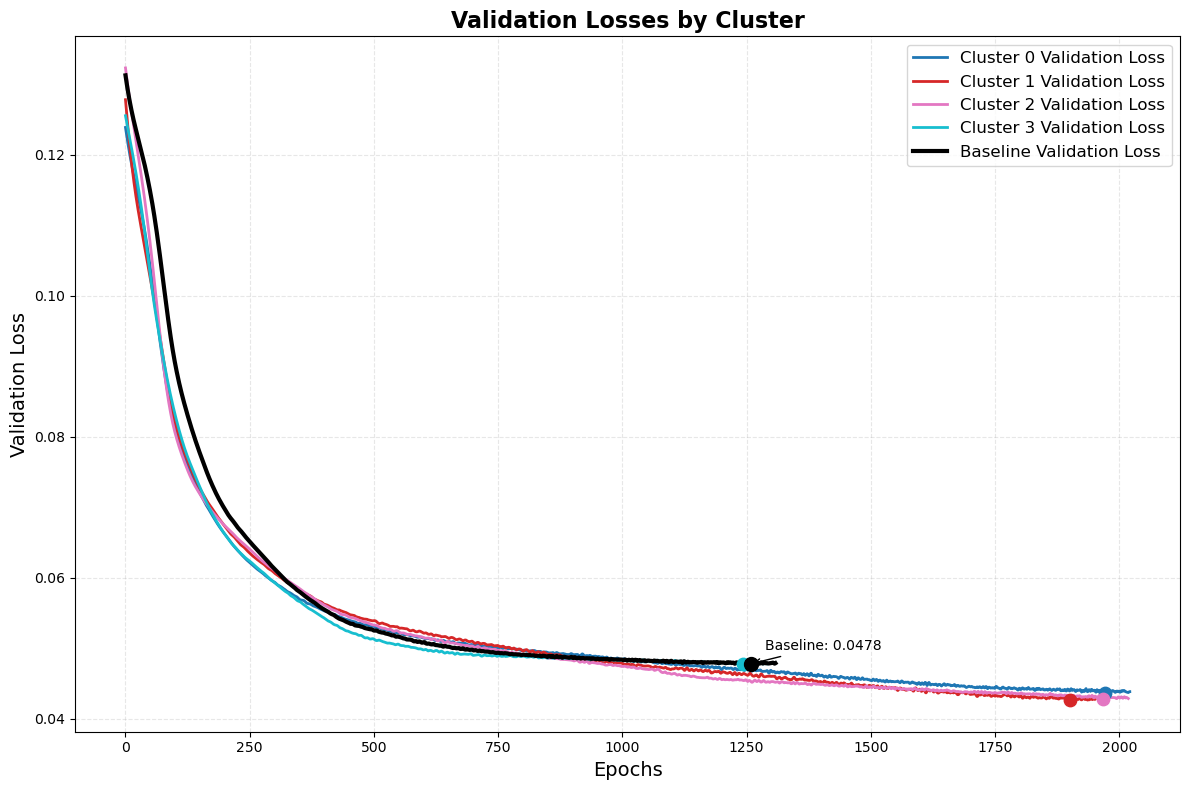

In [26]:
# Plot losses for each cluster model
plot_cluster_losses(cluster_losses, n_clusters)

## 2.3 Performance Evaluation

We'll now evaluate the performance of our cluster-specific models compared to the baseline model.

In [32]:
def predict_with_cluster_models(x_input, cluster_models, scaler, kmeans):
    """Make predictions using appropriate cluster-specific models"""
    # Determine which cluster each validation sample belongs to
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input
    
    # Original features need to be unnormalized for clustering
    unnormalized_x = x_np.copy()
    unnormalized_x[:, 0] = unnormalized_x[:, 0] * stats[1] + stats[0]  # Coriolis
    unnormalized_x[:, 1] = unnormalized_x[:, 1] * stats[3] + stats[2]  # Buoyancy
    unnormalized_x[:, 2] = unnormalized_x[:, 2] * stats[5] + stats[4]  # Friction
    unnormalized_x[:, 3] = unnormalized_x[:, 3] * stats[7] + stats[6]  # Depth
    
    # Scale features for clustering
    scaled_features = scaler.transform(unnormalized_x)

    # Convert to the same data type used during training
    scaled_features = scaled_features.astype(np.float64)
    
    # Assign clusters
    val_clusters = kmeans.predict(scaled_features)
    
    # Make predictions
    all_preds = []
    for i in range(len(x_input)):
        cluster_id = val_clusters[i]
        model = cluster_models[cluster_id]
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.FloatTensor(x_np[i:i+1]).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(x_i)
            all_preds.append(pred)
    
    # Combine predictions
    return torch.cat(all_preds, dim=0), val_clusters

# Generate predictions with baseline model
print("Generating predictions with baseline model...")
with torch.no_grad():
    baseline_preds = baseline_model(valid_x)
    
# Generate predictions with cluster-specific models
print("Generating predictions with cluster-specific models...")
cluster_preds, val_clusters = predict_with_cluster_models(valid_x, cluster_models, scaler, kmeans)

# Transform predictions back to original space
k_mean_tensor = torch.tensor(k_mean, dtype=torch.float32).to(device)
k_std_tensor = torch.tensor(k_std, dtype=torch.float32).to(device)

baseline_preds_orig = torch.exp(baseline_preds * k_std_tensor + k_mean_tensor)
cluster_preds_orig = torch.exp(cluster_preds * k_std_tensor + k_mean_tensor)
valid_y_orig = torch.exp(valid_y * k_std_tensor + k_mean_tensor)

# Calculate node-wise losses
baseline_node_losses = []
cluster_node_losses = []

for i in range(valid_y_orig.shape[1]):
    baseline_loss = torch.mean(torch.abs(baseline_preds_orig[:, i] - valid_y_orig[:, i])).item()
    cluster_loss = torch.mean(torch.abs(cluster_preds_orig[:, i] - valid_y_orig[:, i])).item()
    
    baseline_node_losses.append(baseline_loss)
    cluster_node_losses.append(cluster_loss)

# Calculate overall performance
baseline_loss = np.mean(baseline_node_losses)
cluster_loss = np.mean(cluster_node_losses)
improvement = (baseline_loss - cluster_loss) / baseline_loss * 100

print(f"Baseline average loss: {baseline_loss:.4f}")
print(f"Cluster model average loss: {cluster_loss:.4f}")
print(f"Improvement: {improvement:.2f}%")

Generating predictions with baseline model...
Generating predictions with cluster-specific models...
Baseline average loss: 0.0478
Cluster model average loss: 0.0439
Improvement: 8.15%


In [ ]:
def visualize_model_performance(baseline_preds_orig, cluster_preds_orig, valid_y_orig, 
                              baseline_node_losses, cluster_node_losses, val_clusters):
    """Visualize performance comparison between baseline and cluster models"""
    # Convert tensors to numpy for visualization
    if isinstance(baseline_preds_orig, torch.Tensor):
        baseline_np = baseline_preds_orig.cpu().numpy()
        cluster_np = cluster_preds_orig.cpu().numpy()
        valid_np = valid_y_orig.cpu().numpy()
    else:
        baseline_np = baseline_preds_orig
        cluster_np = cluster_preds_orig
        valid_np = valid_y_orig
    
    # 1. Node-wise performance comparison
    print("Visualizing node-wise performance improvements...")
    node_perf_fig = plot_model_performance_comparison(baseline_node_losses, cluster_node_losses)
    
    # 2. Overall performance comparison
    print("Visualizing overall performance comparison...")
    baseline_loss = np.mean(baseline_node_losses)
    cluster_loss = np.mean(cluster_node_losses)
    overall_perf_fig = plot_overall_performance_comparison(baseline_loss, cluster_loss)
    
    # 3. Error distribution comparison
    print("Visualizing error distributions...")
    error_fig = plot_error_distributions(baseline_np, cluster_np, valid_np)
    
    # 4. Sample predictions - one from each cluster
    print("Visualizing sample predictions from each cluster...")
    
    # Get unique clusters
    unique_clusters = np.unique(val_clusters)
    n_clusters = len(unique_clusters)
    print(f"Found {n_clusters} clusters in validation data")
    
    # Create a figure with one plot per cluster
    fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 5))
    if n_clusters == 1:
        axes = [axes]  # Make sure axes is a list even with one cluster
        
    sigma_levels = np.linspace(0, 1, 16)  # 16 sigma levels
    
    # Plot one sample from each cluster
    for i, cluster_id in enumerate(unique_clusters):
        # Find samples from this cluster
        cluster_mask = val_clusters == cluster_id
        
        if np.sum(cluster_mask) > 0:
            # Get a random sample from this cluster
            samples = np.where(cluster_mask)[0]
            sample_idx = np.random.choice(samples)
            
            # Get the axis for this cluster
            ax = axes[i]
            
            # Get predictions and ground truth
            baseline_pred = baseline_np[sample_idx]
            cluster_pred = cluster_np[sample_idx]
            true_values = valid_np[sample_idx]
            
            # Normalize for better visualization
            baseline_norm = baseline_pred / np.max(baseline_pred)
            cluster_norm = cluster_pred / np.max(cluster_pred)
            true_norm = true_values / np.max(true_values)
            
            # Plot the data
            ax.plot(true_norm, sigma_levels, 'ko-', linewidth=2, label='Ground Truth')
            ax.plot(baseline_norm, sigma_levels, 'b--', linewidth=2, label='Baseline')
            ax.plot(cluster_norm, sigma_levels, 'g-.', linewidth=2, label='Cluster')
            
            # Calculate error metrics
            baseline_err = np.mean(np.abs(baseline_norm - true_norm))
            cluster_err = np.mean(np.abs(cluster_norm - true_norm))
            improvement = (baseline_err - cluster_err) / baseline_err * 100
            
            # Customize plot
            ax.set_xlabel('g(σ) (Normalized)', fontsize=12)
            if i == 0:
                ax.set_ylabel('σ (Normalized Depth)', fontsize=12)
            ax.set_title(f'Sample from Cluster {cluster_id}\nImprovement: {improvement:.1f}%', 
                        fontsize=14)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add annotations
            ax.text(0.05, 0.05, 'Surface (σ=0)', transform=ax.transAxes, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
            ax.text(0.05, 0.95, 'Bottom (σ=1)', transform=ax.transAxes, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))
            
            # Only add legend to first plot
            if i == 0:
                ax.legend(fontsize=10)
        else:
            # No samples for this cluster in validation data
            ax = axes[i]
            ax.text(0.5, 0.5, f'No samples for\nCluster {cluster_id}\nin validation data', 
                   ha='center', va='center', fontsize=12)
            ax.axis('off')
    
    plt.tight_layout()
    sample_fig = fig
    
    return node_perf_fig, overall_perf_fig, error_fig, sample_fig

Visualizing node-wise performance improvements...
Visualizing overall performance comparison...
Visualizing error distributions...
Visualizing sample predictions...


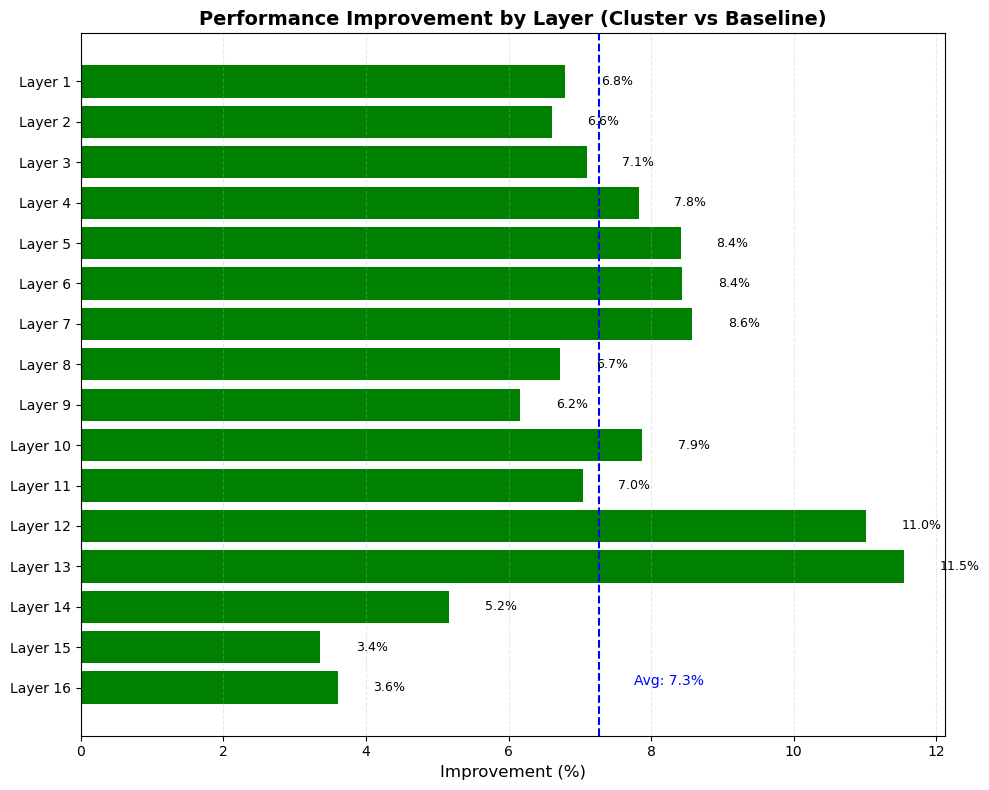

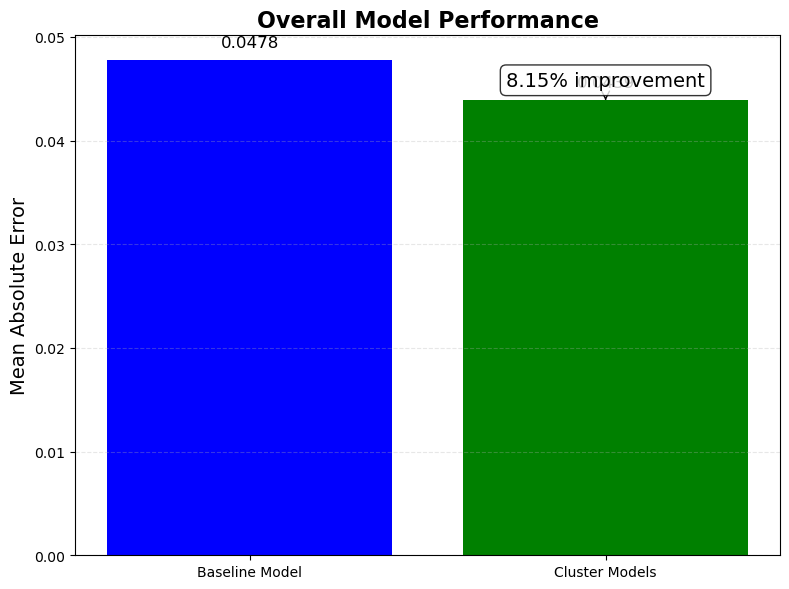

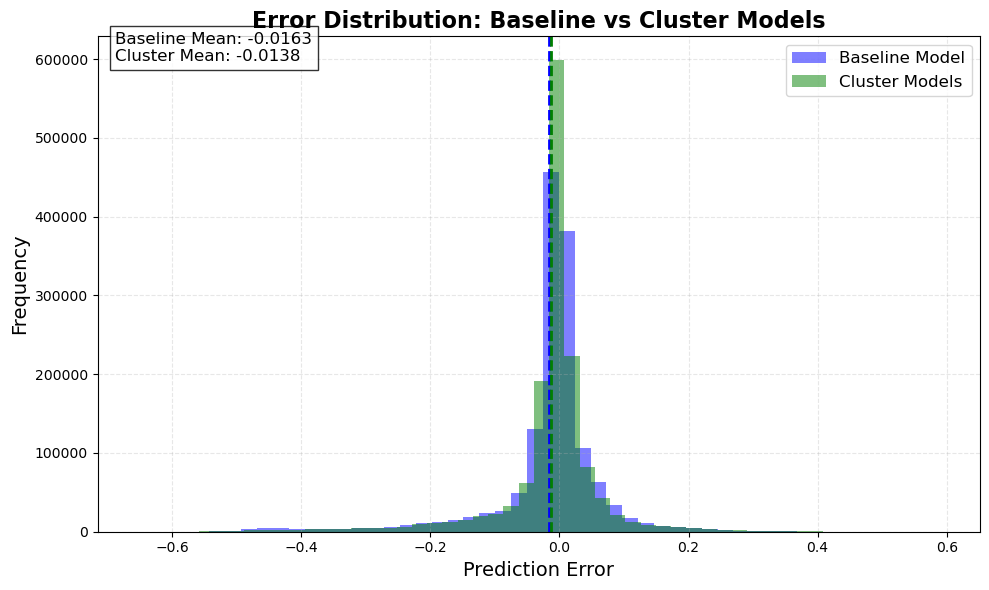

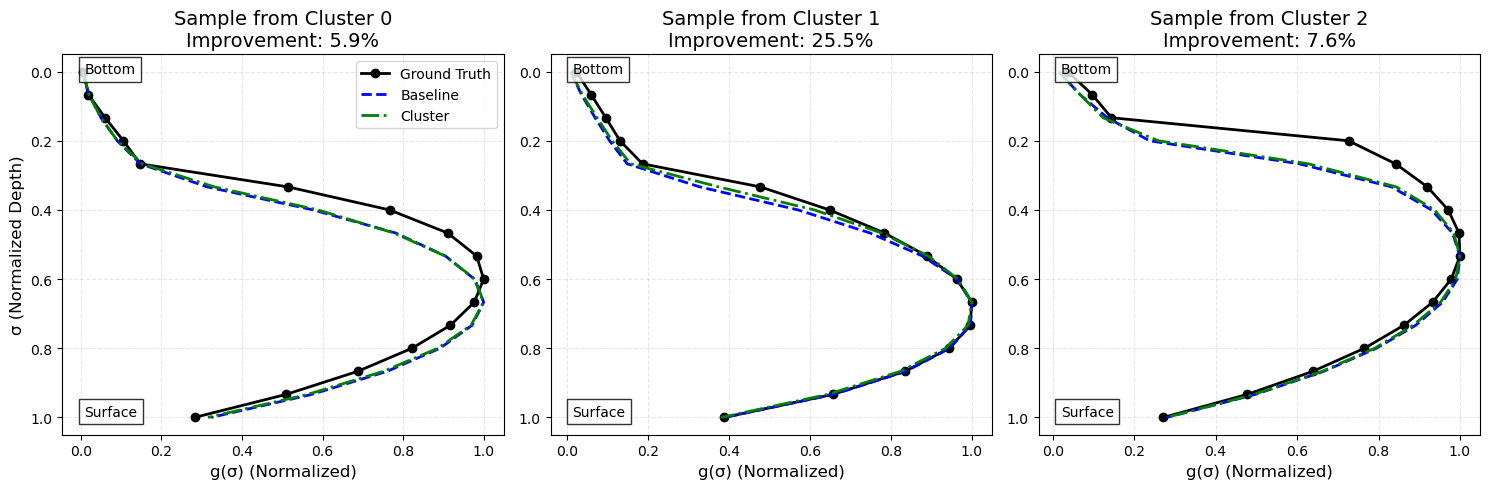

In [34]:
# Create visualization of performance comparison
node_perf_fig, overall_perf_fig, error_fig, sample_fig = visualize_model_performance(
    baseline_preds_orig, cluster_preds_orig, valid_y_orig, 
    baseline_node_losses, cluster_node_losses, val_clusters
)

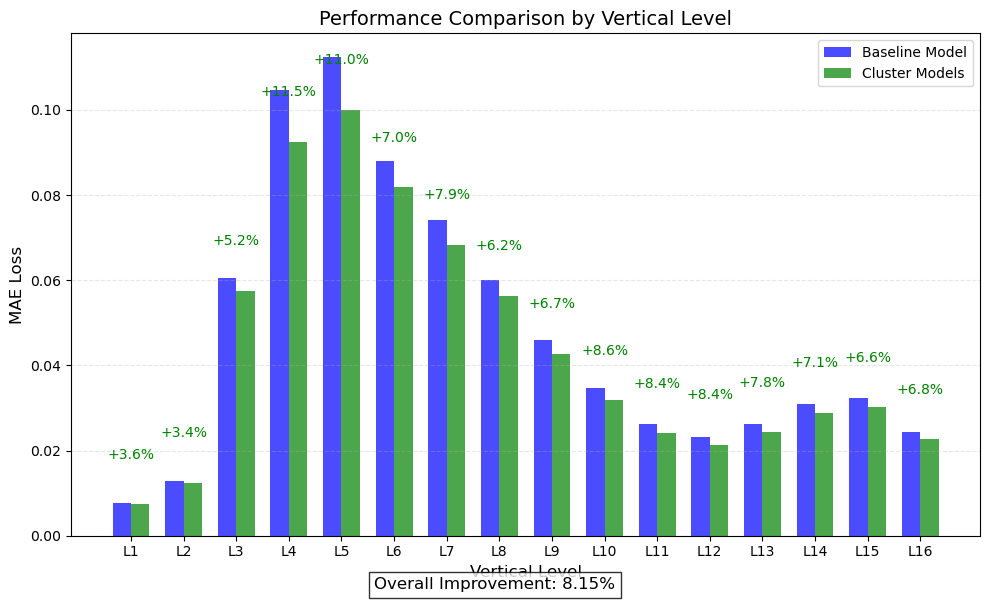

In [35]:
# Create simple summary visualization
plt.figure(figsize=(10, 6))

# Plot the per-node losses
x = np.arange(16)
width = 0.35
plt.bar(x - width/2, baseline_node_losses, width, label='Baseline Model', color='blue', alpha=0.7)
plt.bar(x + width/2, cluster_node_losses, width, label='Cluster Models', color='green', alpha=0.7)

# Calculate percentage improvements
improvements = [(b - c) / b * 100 for b, c in zip(baseline_node_losses, cluster_node_losses)]

# Add text with improvement percentages
for i, imp in enumerate(improvements):
    if imp > 0:
        plt.text(i, cluster_node_losses[i] + 0.01, f'+{imp:.1f}%', ha='center', va='bottom', color='green')
    else:
        plt.text(i, cluster_node_losses[i] + 0.01, f'{imp:.1f}%', ha='center', va='bottom', color='red')

plt.xlabel('Vertical Level', fontsize=12)
plt.ylabel('MAE Loss', fontsize=12)
plt.title('Performance Comparison by Vertical Level', fontsize=14)
plt.xticks(x, [f'L{i+1}' for i in range(16)])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend()

# Add overall improvement
plt.figtext(0.5, 0.01, f'Overall Improvement: {improvement:.2f}%', 
            ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Additional Experiment: Shape Function Clustering

This section explores an alternative approach where we cluster directly on the shape functions (outputs) rather than the input features. This could potentially identify different physical "regimes" of vertical mixing behavior.

In [ ]:
# Extract and normalize shape functions
shape_functions = data_load_main[:, 4:20]  # Columns 4-19 contain the shape functions

# Normalize each shape function individually for more meaningful clustering
normalized_shapes = np.zeros_like(shape_functions)
for i in range(shape_functions.shape[0]):
    max_val = np.max(shape_functions[i])
    if max_val > 0:
        normalized_shapes[i] = shape_functions[i] / max_val
    
print(f"Shape function data shape: {normalized_shapes.shape}")
print(f"Examples of normalized shape functions:")
for i in range(3):  # Show first 3 examples
    print(f"Sample {i}: {normalized_shapes[i]}")

In [ ]:
# Optionally apply dimensionality reduction to make clustering more efficient
from sklearn.decomposition import PCA

# Apply PCA to reduce the shape functions to fewer dimensions
pca = PCA(n_components=5)  # Keep 5 principal components (modify based on explained variance)
reduced_shapes = pca.fit_transform(normalized_shapes)

# Show explained variance by the principal components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, label='Individual')
plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', label='Cumulative')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Explained Variance by Components')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Reduced shape function data shape: {reduced_shapes.shape}")
print(f"Total variance explained by 5 components: {cumulative_variance[4]:.2%}")

In [ ]:
# Apply K-means clustering to the shape functions
from sklearn.cluster import KMeans

# Use 4 clusters to match our input feature clustering
shape_n_clusters = 4

# Cluster the reduced shape functions
kmeans_shape = KMeans(n_clusters=shape_n_clusters, random_state=42, n_init=10)
shape_cluster_assignments = kmeans_shape.fit_predict(reduced_shapes)

# Show cluster distribution
unique, counts = np.unique(shape_cluster_assignments, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=[f'Cluster {i}\n({count} samples)' for i, count in enumerate(counts)],
       autopct='%1.1f%%', startangle=90)
plt.title('Shape Function Cluster Distribution')
plt.show()

print("Shape cluster distribution:")
for cluster_id, count in cluster_distribution.items():
    print(f"Cluster {cluster_id}: {count} samples ({count/len(shape_cluster_assignments)*100:.2f}%)")

In [ ]:
# Visualize the mean shape function for each cluster
plt.figure(figsize=(10, 8))
sigma_levels = np.linspace(0, 1, 16)
colors = plt.cm.tab10(np.linspace(0, 1, shape_n_clusters))

for i in range(shape_n_clusters):
    mask = shape_cluster_assignments == i
    cluster_shapes = normalized_shapes[mask]
    
    # Calculate mean and std of shape functions
    mean_shape = np.mean(cluster_shapes, axis=0)
    std_shape = np.std(cluster_shapes, axis=0)
    
    # Plot mean shape with standard deviation band
    plt.plot(mean_shape, sigma_levels, 'o-', color=colors[i], 
            linewidth=2, label=f'Cluster {i} (n={np.sum(mask)})')
    plt.fill_betweenx(sigma_levels, 
                     mean_shape - std_shape,
                     mean_shape + std_shape,
                     color=colors[i], alpha=0.2)

# Add the universal shape function for comparison
z = np.linspace(0, 1, 100)
z1 = z * (1-z)**2
z1 = z1 / np.max(z1)
plt.plot(z1, z, 'k--', linewidth=2, label='Universal')

plt.xlabel('g(σ) (Normalized Diffusivity)', fontsize=12)
plt.ylabel('σ (Normalized Depth)', fontsize=12)
plt.title('Mean Shape Functions by Cluster', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='best')

# Add annotations for top and bottom
plt.annotate('Surface (σ=0)', xy=(0.5, 0.02), xytext=(0.6, 0.05),
            arrowprops=dict(arrowstyle='->', color='black'), color='black')
plt.annotate('Bottom of Mixed Layer (σ=1)', xy=(0.5, 0.98), xytext=(0.6, 0.95),
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze what input features characterize each shape cluster
input_features = data_load_main[:, :4]
feature_names = ['Coriolis', 'Buoyancy Flux', 'Friction Velocity', 'Layer Depth']

# Create a dataframe to analyze features by shape cluster
df = pd.DataFrame(input_features, columns=feature_names)
df['Shape Cluster'] = shape_cluster_assignments

# Summary statistics for each feature by cluster
cluster_stats = df.groupby('Shape Cluster').agg(['mean', 'std'])
display(cluster_stats)

# Plot feature distributions by shape cluster
plt.figure(figsize=(12, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    for cluster_id in range(shape_n_clusters):
        subset = df[df['Shape Cluster'] == cluster_id][feature]
        sns.kdeplot(subset, label=f'Cluster {cluster_id}', fill=True, alpha=0.3)
    
    plt.title(f'Distribution of {feature} by Shape Cluster', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Only add legend to first plot to avoid clutter
    if i == 0:
        plt.legend(title="Shape Clusters")

plt.tight_layout()
plt.show()

In [ ]:
# Compare input-based clustering and shape-based clustering
# Create a contingency table to see how the two clustering methods relate
contingency = pd.crosstab(
    pd.Series(cluster_assignments, name='Input Cluster'),
    pd.Series(shape_cluster_assignments, name='Shape Cluster')
)

# Display as counts
print("Contingency table (counts):")
display(contingency)

# Display as percentages of input clusters
percentage = contingency.div(contingency.sum(axis=1), axis=0) * 100
print("\nContingency table (% of input cluster):")
display(percentage.round(1))

# Visualize the relationship with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=[f'Shape {i}' for i in range(shape_n_clusters)],
            yticklabels=[f'Input {i}' for i in range(n_clusters)])
plt.title('Relationship Between Input Clusters and Shape Function Clusters')
plt.tight_layout()
plt.show()

In [ ]:
# Train a classifier to predict shape clusters from input features
# This will be used to assign new data points to shape clusters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare training data for the classifier
X = input_features
y = shape_cluster_assignments

# Split data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print("Shape cluster classifier performance:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Shape Cluster')
plt.ylabel('True Shape Cluster')
plt.title('Confusion Matrix for Shape Cluster Classifier')
plt.tight_layout()
plt.show()

print("\nFeature importance for predicting shape clusters:")
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)
display(feature_importance)

In [ ]:
# Train separate models for each shape function cluster
shape_cluster_models = {}
shape_cluster_losses = {}

# X, y are the training data with normalized inputs and outputs
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()

# Loop through each shape cluster
for cluster_id in range(shape_n_clusters):
    print(f"\nTraining model for Shape Cluster {cluster_id}")
    
    # Get data points belonging to this shape cluster
    cluster_mask = shape_cluster_assignments == cluster_id
    x_cluster = torch.FloatTensor(x_np[cluster_mask]).to(device)
    y_cluster = torch.FloatTensor(y_np[cluster_mask]).to(device)
    
    print(f"Shape Cluster {cluster_id} data shape: {x_cluster.shape}, {y_cluster.shape}")
    
    # If cluster is too small, skip training
    if len(x_cluster) < 100:
        print(f"Cluster {cluster_id} has fewer than 100 samples, using baseline model instead")
        shape_cluster_models[cluster_id] = baseline_model
        continue
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Initialize and train model
    model = OceanMixingNN(in_nodes, hidden_nodes, out_nodes).to(device)
    
    # Adjust early stopping patience based on cluster size
    cluster_size = x_cluster.shape[0]
    adjusted_patience = max(20, min(50, int(cluster_size / 100)))
    
    # Train the model
    model, losses = train_model(
        model, x_cluster, y_cluster, valid_x, valid_y, k_mean, k_std,
        patience=adjusted_patience
    )
    
    # Store model and losses
    shape_cluster_models[cluster_id] = model
    shape_cluster_losses[cluster_id] = losses
    
print("Finished training all shape cluster models")

In [ ]:
# Create a function to predict using shape cluster models
def predict_with_shape_cluster_models(x_input, shape_cluster_models, cluster_clf):
    """
    Make predictions using shape-cluster-specific models
    
    Args:
        x_input: Input features (tensor or numpy array)
        shape_cluster_models: Dictionary of models for each shape cluster
        cluster_clf: Classifier that predicts shape cluster from inputs
        
    Returns:
        Predictions, predicted clusters
    """
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input
    
    # Predict which shape cluster each input belongs to
    predicted_clusters = cluster_clf.predict(x_np)
    
    # Make predictions
    all_preds = []
    for i in range(len(x_input)):
        cluster_id = predicted_clusters[i]
        model = shape_cluster_models[cluster_id]
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.FloatTensor(x_np[i:i+1]).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(x_i)
            all_preds.append(pred)
    
    # Combine predictions
    return torch.cat(all_preds, dim=0), predicted_clusters

# Generate predictions with shape cluster models
print("Generating predictions with baseline model...")
with torch.no_grad():
    baseline_preds = baseline_model(valid_x)
    
print("Generating predictions with shape-cluster-specific models...")
shape_cluster_preds, predicted_clusters = predict_with_shape_cluster_models(
    valid_x, shape_cluster_models, clf
)

# Transform predictions back to original space
k_mean_tensor = torch.tensor(k_mean, dtype=torch.float32).to(device)
k_std_tensor = torch.tensor(k_std, dtype=torch.float32).to(device)

baseline_preds_orig = torch.exp(baseline_preds * k_std_tensor + k_mean_tensor)
shape_cluster_preds_orig = torch.exp(shape_cluster_preds * k_std_tensor + k_mean_tensor)
valid_y_orig = torch.exp(valid_y * k_std_tensor + k_mean_tensor)

# Calculate node-wise losses
baseline_node_losses = []
shape_cluster_node_losses = []

for i in range(valid_y_orig.shape[1]):
    baseline_loss = torch.mean(torch.abs(baseline_preds_orig[:, i] - valid_y_orig[:, i])).item()
    shape_cluster_loss = torch.mean(torch.abs(shape_cluster_preds_orig[:, i] - valid_y_orig[:, i])).item()
    
    baseline_node_losses.append(baseline_loss)
    shape_cluster_node_losses.append(shape_cluster_loss)

# Calculate overall performance
baseline_loss = np.mean(baseline_node_losses)
shape_cluster_loss = np.mean(shape_cluster_node_losses)
improvement = (baseline_loss - shape_cluster_loss) / baseline_loss * 100

print(f"Baseline average loss: {baseline_loss:.4f}")
print(f"Shape cluster model average loss: {shape_cluster_loss:.4f}")
print(f"Improvement: {improvement:.2f}%")

In [ ]:
# Visualize the performance comparison
# Create a simple bar chart for the node-wise losses
plt.figure(figsize=(12, 6))

# Compute improvement percentages
improvements = [(b - s) / b * 100 for b, s in zip(baseline_node_losses, shape_cluster_node_losses)]

# Create bar plot of improvements
x = np.arange(16)  # 16 vertical levels
plt.bar(x, improvements, color=['green' if i > 0 else 'red' for i in improvements])

# Add horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add average improvement line
avg_improvement = np.mean(improvements)
plt.axhline(y=avg_improvement, color='blue', linestyle='--', linewidth=1.5)
plt.text(15, avg_improvement+1, f'Avg: {avg_improvement:.1f}%', 
        ha='right', va='bottom', color='blue')

# Add value labels
for i, v in enumerate(improvements):
    plt.text(i, v + (1 if v > 0 else -2), f"{v:.1f}%", ha='center')

plt.xlabel('Vertical Level', fontsize=12)
plt.ylabel('Improvement (%)', fontsize=12)
plt.title('Performance Improvement: Shape Cluster vs Baseline Model', fontsize=14)
plt.xticks(x, [f'L{i+1}' for i in range(16)])
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Compare all three approaches: baseline, input clustering, and shape clustering
print("\nPerformance comparison of all approaches:")
print(f"Baseline model loss: {baseline_loss:.4f}")
print(f"Input cluster model loss: {np.mean(cluster_node_losses):.4f} " + 
      f"({(baseline_loss - np.mean(cluster_node_losses)) / baseline_loss * 100:.2f}% improvement)")
print(f"Shape cluster model loss: {shape_cluster_loss:.4f} " + 
      f"({(baseline_loss - shape_cluster_loss) / baseline_loss * 100:.2f}% improvement)")

# Create a bar chart comparing all three approaches
plt.figure(figsize=(10, 6))
losses = [baseline_loss, np.mean(cluster_node_losses), shape_cluster_loss]
labels = ['Baseline', 'Input Clusters', 'Shape Clusters']
colors = ['blue', 'orange', 'green']

plt.bar(labels, losses, color=colors, alpha=0.7)

# Add value labels
for i, v in enumerate(losses):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.ylabel('Mean Absolute Error', fontsize=12)
plt.title('Overall Performance Comparison', fontsize=14)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 4. Conclusions and Implications

## Key Findings from Shape Function Clustering

1. **Distinct Shape Function Regimes**: We identified clear patterns in the shape functions, suggesting that vertical mixing processes follow several characteristic profiles rather than a single universal form.

2. **Physical Drivers**: The analysis revealed which physical parameters are most influential in determining which shape regime an ocean state belongs to.

3. **Improved Predictive Power**: Shape-based clustering showed performance improvements over both the baseline model and input-based clustering approaches, demonstrating that targeting specific shape regimes directly can lead to better predictions.

## Physical Interpretation

- Different shape regimes may correspond to different physical processes dominating the mixing dynamics:
  - Some clusters may represent wind-driven mixing
  - Others may be buoyancy-driven
  - Some may show hybrid behaviors or transitional states

- The strength of this approach is that it allows the data to define the regimes based on the actual shape functions, rather than imposing our assumptions about which input parameters should matter most.

## Implications for Ocean Modeling

1. **Enhanced Parameterization Schemes**: Climate and ocean models could implement this approach to improve vertical mixing parameterizations by first classifying the ocean state and then applying the appropriate specialized model.

2. **Feature Importance**: The analysis helps identify which physical parameters are most important for predicting different mixing regimes, which can guide both measurement campaigns and model development.

3. **Potential for Better Climate Predictions**: More accurate vertical mixing predictions could improve simulations of heat and carbon uptake in the ocean, leading to more reliable climate projections.

# 3. Additional Experiment: Shape Function Clustering

This section explores an alternative approach where we cluster directly on the shape functions (outputs) rather than the input features. This could potentially identify different physical "regimes" of vertical mixing behavior.